In [1]:
# Uber Vs Lyft - Which Service Is Better?

### Understanding the quality of Rideshare Apps, Uber & Lyft, based on factors such as distance traveled, pricing and weather conditions in Winter 2018, Boston (MA)

In [2]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

%matplotlib inline
import seaborn as sns

In [3]:
#Refrence to Csv files 
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

In [5]:
## Part 1 - Cleaning our data

#### Our Cab Ride data contains a list of rides taken between a range of sources and destinations, along with their prices, surge multipliers and ride type (example - Uber Pool or Uber XL). Our Weather data gives us a selection of weather conditions measure against a series of similar timestamps.

In [6]:
# Cleaning Weather Data
# The timestamps were listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [7]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [8]:
#Merge the datesets into a single one based on time_stamp and location
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ) )
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [9]:
#dataframe info 
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [10]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [11]:
#Count the numbers of temp 
final_df["temp"].count

<bound method Series.count of 0         41.07
1         40.80
2         40.86
3         40.80
4         40.81
          ...  
251822    31.20
251823    30.80
251824    30.80
251825    30.91
251826    31.20
Name: temp, Length: 251827, dtype: float64>

In [12]:
# Adding the day of the week to our table to see if that may have any correlation to weather
final_df["day_of_week"]=final_df["date"].dt.day_name()
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday


In [13]:
#Adding Month to the table 
final_df["month"] = final_df['date'].dt.month
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [14]:
# Formatting some columns to show accurate values
final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [15]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)", "month":"Month"})

final_df = final_df[["Date","Month","Weekday","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Month,Weekday,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,11,Monday,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,11,Monday,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,11,Monday,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,11,Monday,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,11,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [16]:
#count of Rides with price 0 
final_df [ final_df["Price($)"]==0]["Price($)"].count()

20098

In [17]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

In [18]:
## Part 2 - Understanding our Dataset
#### With a large set of data, we want to begin by understanding the general marketability of Uber vs Lyft, like what's the general preference of rides or who makes more money. This is our first step before diving into more deeper analyses

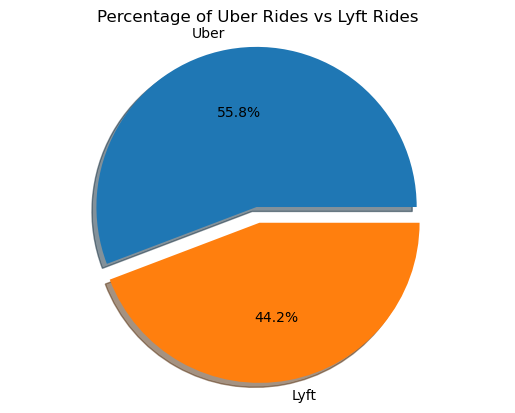

In [19]:
#Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()

percentages = (ride_counts / ride_counts.sum()) * 100
explode = [0.05] * len(percentages)


plt.pie(percentages, labels=percentages.index, explode=explode, shadow=True, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.axis('equal')
plt.show()

In [20]:
#find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


In [21]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
uber_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Uber Ride Count":ride_counts})
uber_ranges

,Distance Range,Uber Ride Count
0,0-2 miles,67317
1,2-4 miles,63131
2,4-6 miles,8679
3,6-8 miles,1339


In [22]:
# Filter the DataFrame to include only Lyft rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Lyft rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
lyft_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Lyft Ride Count":ride_counts})
lyft_ranges

,Distance Range,Lyft Ride Count
0,0-2 miles,51883
1,2-4 miles,51591
2,4-6 miles,7865
3,6-8 miles,22


In [23]:
# Merge data into a single table for easy plotting
range_df=pd.merge(uber_ranges,lyft_ranges, on="Distance Range", how="left")
range_df

,Distance Range,Uber Ride Count,Lyft Ride Count
0,0-2 miles,67317,51883
1,2-4 miles,63131,51591
2,4-6 miles,8679,7865
3,6-8 miles,1339,22


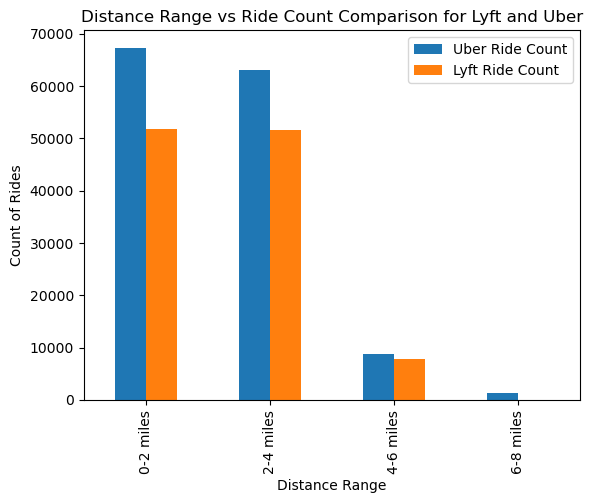

In [24]:
# Plotting a bar chart to show rides taken for various distance ranges per rideshare app
ax=range_df.plot.bar()
labels=range_df["Distance Range"]
ax.set_xticklabels(labels)
plt.title("Distance Range vs Ride Count Comparison for Lyft and Uber")
plt.xlabel("Distance Range")
plt.ylabel("Count of Rides")
plt.show()

In [25]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()
revenue_df


Rideshare_App
Lyft    1930455.15
Uber    1902764.00
Name: Price($), dtype: float64

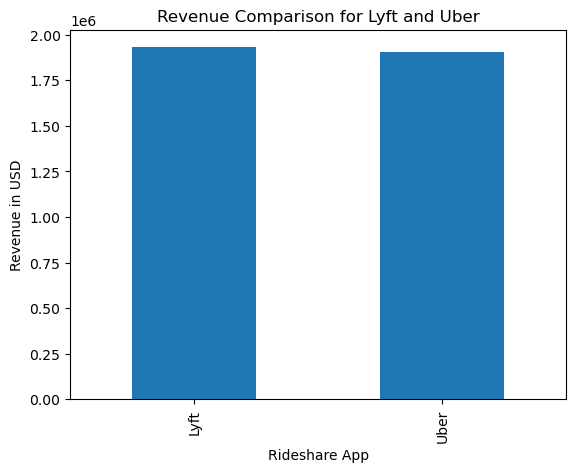

In [26]:
#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [27]:
#Lyft Monthly Revenue 
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("Month")["Price($)"].sum()
lyft_monthly_rev

Month
11    1126795.80
12     803659.35
Name: Price($), dtype: float64

In [28]:
#Uber Monthly Revenue 
uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["Month"])["Price($)"].sum()
uber_monthly_rev

Month
11    1117151.5
12     785612.5
Name: Price($), dtype: float64

In [29]:
#Created Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

,Lyft,Uber
Month,,
11,1126795.80,1117151.5
12,803659.35,785612.5


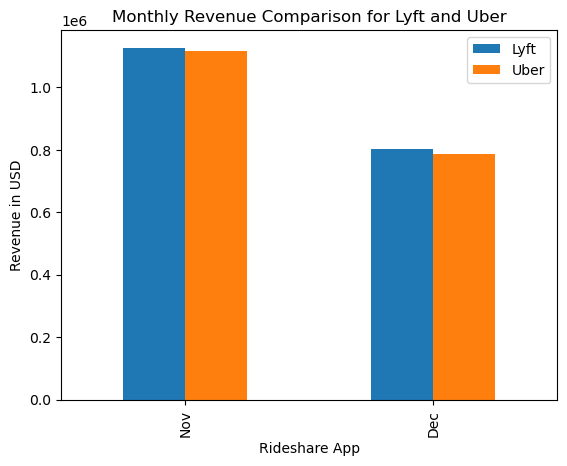

In [30]:
#Plotting a bar chart to show revenue based on month, per rideshare app
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [31]:
# In order to look at the number of rides taken per hour, we need to extract the information from the timestamps

final_df["Hour"]=final_df["Date"].dt.hour
final_df.head()

,Date,Month,Weekday,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph),Hour
0,2018-11-26 03:40:46.318000128,11,Monday,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36,3
1,2018-11-26 03:40:46.319000064,11,Monday,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55,3
2,2018-11-26 03:40:46.319000064,11,Monday,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60,3
3,2018-11-26 03:40:46.320000000,11,Monday,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55,3
4,2018-11-26 03:40:46.320000000,11,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36,3


In [32]:
# Let's find average number of Uber Rides taken per day and per hour

uber=final_df.loc[final_df["Rideshare_App"]=="Uber"]

grouped_hour_day = uber.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_uber = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_uber)

Hour  Weekday  
0     Friday        516.0
      Monday        644.0
      Saturday      475.0
      Sunday        501.0
      Thursday     2336.0
                    ...  
23    Saturday      529.0
      Sunday        844.0
      Thursday      489.0
      Tuesday       828.0
      Wednesday    2345.0
Length: 163, dtype: float64


In [33]:
# Let's find average number of Lyft Rides taken per day and per hour

lyft=final_df.loc[final_df["Rideshare_App"]=="Lyft"]

grouped_hour_day = lyft.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_lyft = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_lyft)

Hour  Weekday  
0     Friday        420.0
      Monday        436.0
      Saturday      461.0
      Sunday        435.0
      Thursday     1879.0
                    ...  
23    Saturday      407.0
      Sunday        681.0
      Thursday      447.0
      Tuesday       732.0
      Wednesday    1711.0
Length: 163, dtype: float64


In [34]:
# Defining a function that'll allow us to easily plot some timeseries graphs

def plot(dataframe):
# Create a list of weekdays to use as labels
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a figure and axis objects
    fig, ax = plt.subplots(figsize=(10,6))

# Iterate over each weekday and plot a line for the count of car rides
    for weekday in weekdays:
        data = dataframe.loc[dataframe.index.get_level_values('Weekday') == weekday]
        ax.plot(data.index.get_level_values('Hour'), data, label=weekday)

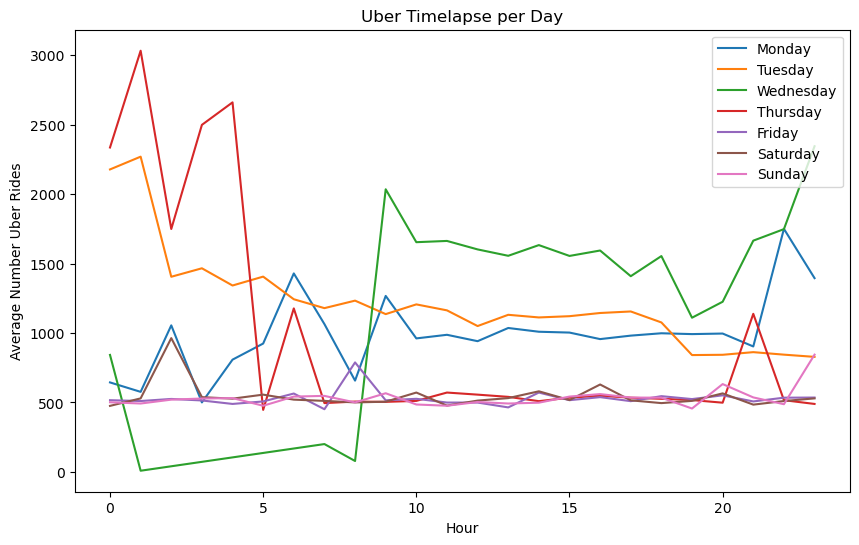

In [35]:
# Average Rides for Uber Timeseries
plot(mean_rides_uber)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Uber Rides')
plt.title("Uber Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.show()

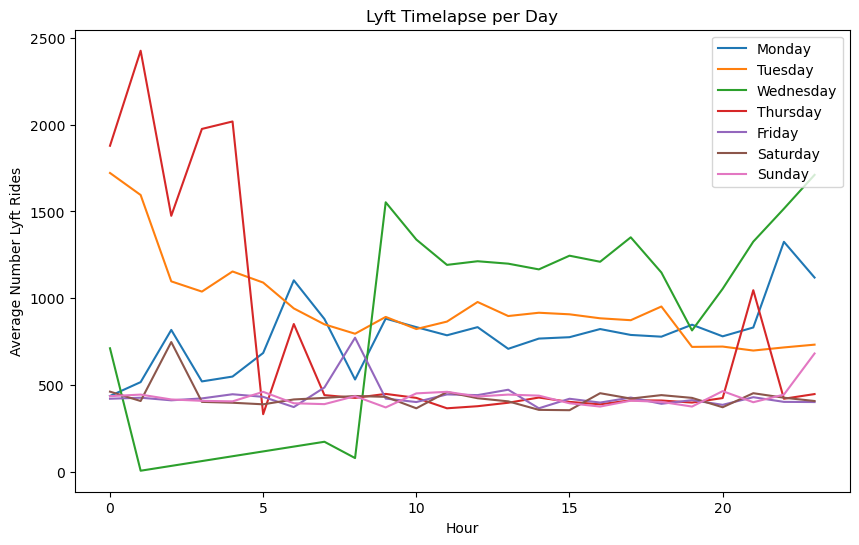

In [36]:
# Average Rides for Lyft Timeseries
plot(mean_rides_lyft)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Lyft Rides')
plt.title("Lyft Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.show()

# Statistical analysis on Price based on Each App

In [37]:
#Generate a summary statistics of mean, median, variance, standard deviation, and SEM of the price for Lyft and Uber 

ride_app = final_df.groupby("Rideshare_App")

count_rides = ride_app["Price($)"].count()
mean_price = ride_app["Price($)"].mean()
median_price = ride_app["Price($)"].median()
var_price = ride_app["Price($)"].var()
std_price = ride_app["Price($)"].std()
sem_price = ride_app["Price($)"].sem()
min_price = ride_app["Price($)"].min()
max_price = ride_app["Price($)"].max()
price_rideApp_df = pd.DataFrame({"Price Mean":mean_price , 
                            "Price Median ":median_price,
                             "Price Variance":var_price,
                             "Price Std. Dev.":std_price,
                             "Price Std. Err.":sem_price,
                                "Total rides" :count_rides,
                                "Max Price" : max_price,
                                "Min Price": min_price})
price_rideApp_df

,Price Mean,Price Median,Price Variance,Price Std. Dev.,Price Std. Err.,Total rides,Max Price,Min Price
Rideshare_App,,,,,,,,
Lyft,17.335110,16.5,100.338586,10.016915,0.030017,111361,92.0,2.5
Uber,13.546082,11.0,93.315272,9.659983,0.025775,140466,89.5,0.0


### Maryam's Analysis:
Lyft has higher price on average (17.34 vs.13.55  )and the Standard deviation is higher (10.02 vs. 9.66). 
Lyft max price is 92.0 and the min price is 2.5.
Uber max price is 89.5 and the min price is 0.0.s

In [38]:
## Part 3 - Rideshare Behavior vs Weather
#### Weather plays a pivotal role in commute! In our given data, there are plausible elements of nature that could potentially affect how one gets from point A to point B. Now that we have a general idea of what app is preferable, let's add a second layer to the analyses.

In [39]:
# In order to better visualize the amount of rainfall, we need to convert our unit of measurement to millimeters and also derive count of rides per day

final_df["Rainfall(mm)"]=final_df["Rainfall(in)"]*25.4
final_df["Date by hour"]=final_df["Date"].dt.strftime("%Y-%m-%d %H:%M")

# Making a list of days in the given week. This will eventually be our x-axis
days_of_the_week=final_df["Date by hour"].unique()

# Splitting the edited dataframe by Rideshare App
uber_split = final_df.loc[final_df["Rideshare_App"]=="Uber"]
lyft_split = final_df.loc[final_df["Rideshare_App"]=="Lyft"]

In [40]:
# Finding out the count of rides taken per day of the week for Uber

uber_grouped=uber_split.groupby(["Date by hour"])
uber_ride_count=uber_grouped.count()["Destination"]
uber_ride_count.head()

Date by hour
2018-11-26 03:40    41
2018-11-26 04:40    52
2018-11-26 04:41    55
2018-11-26 04:43    50
2018-11-26 04:49    48
Name: Destination, dtype: int64

In [41]:
# Finding out the count of rides taken per day of the week for Uber

lyft_grouped=lyft_split.groupby(["Date by hour"])
lyft_ride_count=lyft_grouped.count()["Destination"]
lyft_ride_count.head()

Date by hour
2018-11-26 03:40    43
2018-11-26 04:40    32
2018-11-26 04:41    29
2018-11-26 04:43    34
2018-11-26 04:49    36
Name: Destination, dtype: int64

In [ ]:
# Finding average rainfall each day

#ave_rainfall=day_grouped.mean()["Rainfall(mm)"]
#ave_rainfall.head()

In [ ]:
# Finding average wind speed each day

#ave_wind_speed=day_grouped.mean()["Wind_Speed(mph)"]
#ave_wind_speed.head()

In [ ]:
# Finding average wind speed each day

#ave_cloudiness=day_grouped.mean()["Cloudiness(%)"]
#ave_cloudiness.head()

In [ ]:
# Create the final dataframe for plotting

#rides_vs_weather = pd.DataFrame({"Uber Ride Count":uber_ride_count,"Lyft Ride Count":lyft_ride_count,"Average Rainfall (mm)":ave_rainfall,"Average Wind Speed (mph)":ave_wind_speed, "Average Cloudiness (%)":ave_cloudiness},index=days_of_the_week)
#rides_vs_weather.head()

In [ ]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
#plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
#plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

#plt.legend()

# plt.xlabel("Average Rainfall (mm)")
# plt.ylabel("Ride Counts")
# plt.title("Ride Counts affected by Rainfall")
# plt.show()

In [ ]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
# plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
# plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

# plt.legend()

# plt.xlabel("Average Windspeed (mph)")
# plt.ylabel("Ride Counts")
# plt.title("Ride Counts affected by Windspeed")
# plt.show()

In [ ]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
# plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
# plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

# plt.legend()

# plt.xlabel("Average Cloudiness (%)")
# plt.ylabel("Ride Counts")
# plt.title("Ride Counts affected by Cloudiness")
# plt.show()

# Determin any pattern change of the average price on each day of the week base on each App
###  Plot Line bar to show the comparison 

In [ ]:
# Create a sorted value list to sort day of the week result
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [ ]:
# higehst price of the Uber rides / indexed based on cats variable
uber_rides = final_df[ final_df["Rideshare_App"]=="Uber"]
uber_highestday_price=uber_rides.groupby(["Weekday"])["Price($)"].mean().reindex(cats)
uber_highestday_price

In [ ]:
# higehst price of the Lyft rides / indexed based on cats variable
lyft_rides = final_df[ final_df["Rideshare_App"]=="Lyft"]
lyft_highestday_price=lyft_rides.groupby(["Weekday"])["Price($)"].mean().reindex(cats)
lyft_highestday_price


In [ ]:
#created the line chart to show price difference based on most expensive day of the week for each ride app 
plt.figure(figsize=(16, 8), dpi=150)
uber_highestday_price.plot(color ="r", label ="uber highest price perday")
lyft_highestday_price.plot(color ="b", label ="lyft highest price perday")
plt.legend()


### Maryam's Analysis:
Avaerage of the price for each app on different days of the week is relatively constant and does not change a lot. 

In [ ]:
#Analysis of Average Surge Multiplier vs Day of Week
Surge_Weekday_df=final_df.groupby('Weekday')['Surge_Multiplier'].mean()

plt.plot(Surge_Weekday_df.index,Surge_Weekday_df.values)
plt.title("Average Surge Multiplier vs Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Surge Multiplier")
plt.show()

In [ ]:
ridetype=['UberPool','Shared']

ride_type_count=final_df[final_df['Ride_Type'].isin(ridetype)].groupby('Ride_Type')['Ride_Type'].count()

plt.bar(ride_type_count.index,ride_type_count.values,width=0.4)
plt.title('Carpool Type Vs Number of rides')
plt.xlabel('CarPool Type')
plt.ylabel('Number of rides')
plt.show()

# Determin Price outliers for each App and plot Boxplot 

In [ ]:
# create rides into list for loop
ride_list = ["Lyft", "Uber"]

#Create empty list to fill with price data (for plotting)
price_list =[]

for ride in ride_list:
    
    price = final_df[ final_df["Rideshare_App"]==ride]["Price($)"] 
    
    price_list.append(price)
    
    # Determine outliers using upper and lower bounds
    quartiles = price.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    # print if the counter is empty and add a space between each regimen
    
   
    print(f"The IQR data for {ride} is:")
    print(f"The lower quartile of {ride} is: {lowerq}")
    print(f"The upper quartile of {ride} is: {upperq}")
    print(f"The interquartile range of {ride} is: {iqr}")
    print(f"The the median of {ride} is: {quartiles[0.5]}")
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"")
   


In [ ]:
# Generate a box plot that shows the distrubution of the price based on each ride app.
flierprops = dict(marker='o', markerfacecolor='r', markersize=10, markeredgecolor='black')

fig1, ax1 = plt.subplots()
ax1.set_ylabel(" Price $")
ax1.set_xlabel("Ride")
ax1.boxplot(price_list, flierprops=flierprops)
ax1.set_xticklabels(ride_list)

plt.show()

# Plot Heatmap 
#### 1- Correlation among All the Data in the  DataFrame
#### 2- Correlation among Weather condition and Price 
#### 3- Correlation among Daily weather conditions and Revenue 

In [ ]:
# Plot the correlation heat map among numeric columns
# calculate the correlation matrix on the numeric columns
corr = final_df.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

In [ ]:
# calculate the correlation matrix on the wehater conditions and price
conditions_list = ["Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)","Price($)"]

corr = final_df.loc[:,conditions_list].select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

In [ ]:
#aggregate the data to calculate the revenue and get the mean for the rest for each specific day 

#create a day field 
final_df["day"] = final_df["Date"].dt.date
by_date_df = final_df.groupby("day")
#create revenue and add a column called revenue to by_date dataframe

#aggregate the price column to get the revenue 
revenue = by_date_df["Price($)"].sum()
by_date_df = by_date_df.mean()
by_date_df["revenue"] = revenue


by_date_df


In [ ]:
# calculate the correlation matrix on revenue based on the wehater conditions on specific days
conditions_list = ["Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)","Distance(m)","revenue"]

corr = by_date_df.loc[:,conditions_list].select_dtypes('number').corr()


# plot the heatmap
sns.heatmap(corr)

### Maryam's Analysis:
    Revenue has the highest correlation with Rainfall. The Rainfall, Cloudiness, Humidity, Wind_Speed have the positive effect on revenue. The distance has the negative effect, because the bulk of the price comes from the initial charge on each ride per day.  
    So, The best strategy to increase revenue is to focuse on more short distance rides. 


# Linear Regression of Distance Vs. Average of Price : 

In [ ]:
#Bining the distance
bins = [0,1,2,3,4,5,6,7,8]
final_df["dist"] =  pd.cut(final_df["Distance(m)"].astype(float),bins)
final_df[["Distance(m)","dist"]].head(20)


In [ ]:
#Study the relationship between price and the distance
# Calculate the correlation coefficient and a linear regression model 
#  for price and distance for the entire rides based on different app


uber_rides=final_df.loc[final_df["Rideshare_App"] =="Uber"]
uber_rides = uber_rides.groupby("dist").mean()

# Count the number of Lyft rides within each distance range

uber_price = uber_rides["Price($)"]
uber_distance = uber_rides["Distance(m)"]

corr = round(st.pearsonr(uber_distance, uber_price )[0],2)
print(f"The correlation between price of Uber rides and the Distance  {corr}")


#linear regression model
linear_reg = st.linregress( uber_rides["Distance(m)"],uber_rides["Price($)"])
linear_reg



In [ ]:
# plot the regression line on the scatter plot
uber_rides=final_df.loc[final_df["Rideshare_App"] =="Uber"]


plt.scatter(uber_distance, uber_price)

#linear regression equation and plot the line
uber_price_predict = uber_distance * linear_reg.slope + linear_reg.intercept
plt.plot(uber_distance, uber_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg.slope,2)) + "x + " + str(round(linear_reg.intercept,2))
plt.annotate(line_eq,(5,15),fontsize=15,color="red")
plt.title("Linear Regression of Distance Vs. Average of Price (Uber)")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.show()

In [ ]:
#Study the relationship between price and the distance
# Calculate the correlation coefficient and a linear regression model 
# for price and distance for the entire rides based on different app


lyft_rides=final_df.loc[final_df["Rideshare_App"] =="Lyft"]
lyft_rides = lyft_rides.groupby("dist").mean()
lyft_rides = lyft_rides.dropna()

# Count the number of Lyft rides within each distance range

lyft_price = lyft_rides["Price($)"]
lyft_distance = lyft_rides["Distance(m)"]

corr = round(st.pearsonr(lyft_distance, lyft_price )[0],2)
print(f"The correlation between price of Lyft rides and the Distance  {corr}")


#linear regression model
linear_reg = st.linregress( lyft_rides["Distance(m)"],lyft_rides["Price($)"])
linear_reg



In [ ]:
# plot the regression line on the scatter plot
lyft_rides=final_df.loc[final_df["Rideshare_App"] =="Lyft"]


plt.scatter(lyft_distance, lyft_price)
#linear regression equation and plot the line
lyft_price_predict = lyft_distance * linear_reg.slope + linear_reg.intercept
plt.plot(lyft_distance, lyft_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg.slope,2)) + "x + " + str(round(linear_reg.intercept,2))
plt.annotate(line_eq,(3.5,20),fontsize=15,color="red")
plt.title("Linear Regression of Distance Vs. Average of Price (Lyft)")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.show()


Maryam's Analysis:
Lyft charges more for based rides compare to Uber (10.05 vs. 9.50) and charges more for each additional miles compare to Uber (3.38 vs. 1.93) 

# Comparison of Distance vs. Price for Each ride 
1- The problem: How do we know if Distance would effect the price charges on each app?
2- The solution: ANOVA - does Distance not effect the price that each ride charges?

In [ ]:
#Create BoxPlot to compare mean of the distance vs Price
#Uber
uber_rides.boxplot("Distance(m)", by="Price($)", figsize=(20, 10))

In [ ]:
# Extract individual groups based on different price 
group0 = uber_rides[uber_rides["Price($)"] <= 30]["Distance(m)"]
group1 = uber_rides[uber_rides["Price($)"] <= 60]["Distance(m)"]
group2 = uber_rides[uber_rides["Price($)"] <= 90]["Distance(m)"]


In [ ]:
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

In [ ]:
#Create BoxPlot to compare mean of the distance vs Price
#Lyft 
lyft_rides.boxplot("Distance(m)", by="Price($)", figsize=(20, 10))

In [ ]:
# Extract individual groups based on different price 
group0 = lyft_rides[lyft_rides["Price($)"] <= 30]["Distance(m)"]
group1 = lyft_rides[lyft_rides["Price($)"] <= 60]["Distance(m)"]
group2 = lyft_rides[lyft_rides["Price($)"] <= 90]["Distance(m)"]


In [ ]:
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

### Maryam's Analysis:
#### Uber : 
Uber includes more rides, and has the p-Value of pvalue=1.1480829994832444e-127 which is a very small number. So, the null hypothesis that Distance would not have effect on the Price can be rejected. 
#### Lyft : 
Lyft includes less rides, and had the pvalue=4.858273627090331e-168 which will also reject the null hypohesis that Distance would not have an affect on Price. 